# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [2]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [3]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

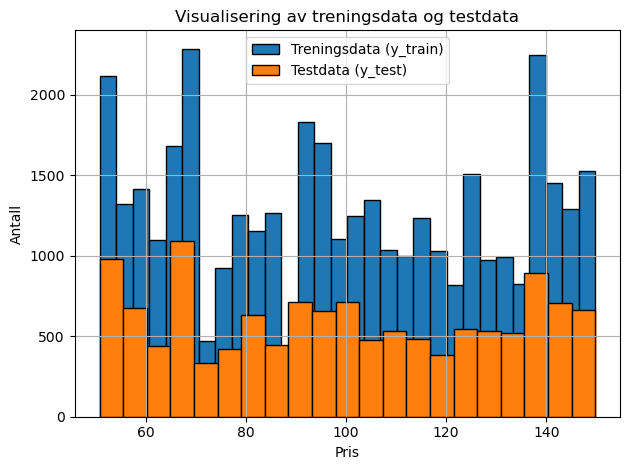

In [4]:
#TODO: visualiser y_train og y_test i et histogram

#Her er implementert Freedman-Diaconis' Regel for å beregne optimalt antall bins
def freedman_diaconis(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    bin_width = 2 * iqr / (len(data) ** (1/3))
    return int(np.ceil((np.max(data) - np.min(data)) / bin_width))


y_train.hist(bins=freedman_diaconis(y_train), edgecolor="black", label="Treningsdata (y_train)")
y_test.hist(bins=freedman_diaconis(y_test), edgecolor="black", label="Testdata (y_test)")
plt.ylabel("Antall")
plt.xlabel("Pris")
plt.title("Visualisering av treningsdata og testdata")
plt.tight_layout()
plt.legend()
plt.show()

**Svar:**

Basert på kun det man ser i histogrammet er det en regresjonsproblem som skal løses.

Grunnen til dette er kontinuerlig fordeling som indikerer at y er en kontinuerlig variabel.

Dette stemmer fordi y_train og y_test er basert på variabelen y som representerer "cost", altså priser.


#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [5]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
    
    #Lager korrelasjonsmatrise
    corr_matrix = X_temp.corr()
    
    #Fjerner duplikat resultater fra korrelasjonsmatrisen
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    #Viser korrelasjonsmatrisen
    plt.figure(figsize=(18, 10))
    sns.heatmap(corr_matrix, annot=True, mask=mask, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Korrelasjonsmatrise')
    plt.tight_layout()
    plt.show()

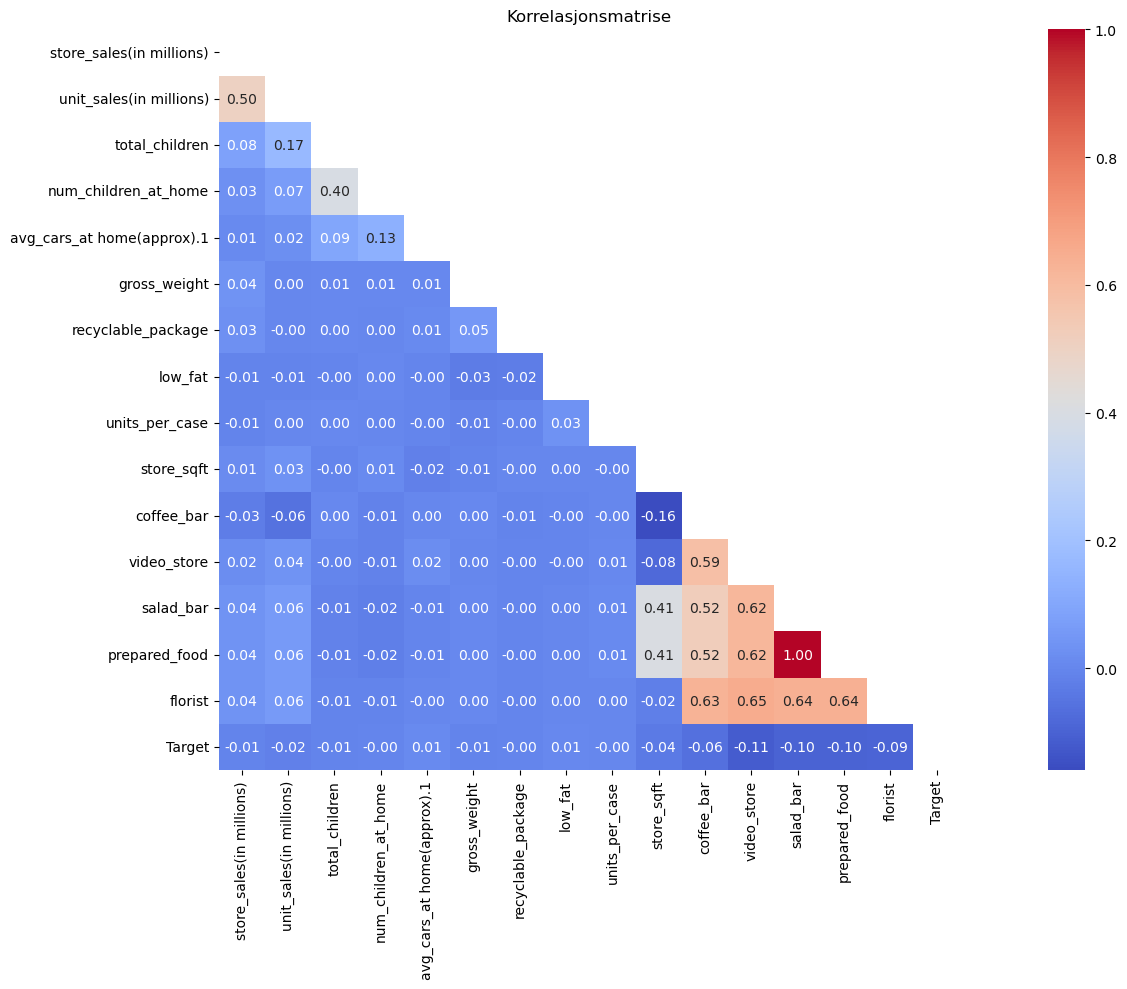

In [6]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

Egenskaper som korrelerer mest med target er video_store, salad_bar, prepared_food og florist.

Her er det ganske svak lineær korrelasjon mellom egenskaper og target.

Dette kan tyde på at egenskapene har ikke-lineær sammenheng med target.

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [7]:
#TODO: Utfør hyperparametersøk for en modell

"""param_dist = {
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 5),
    "min_samples_leaf": randint(1, 4)  
}"""

#Bestemmer intervall over mulige verdier til hyperparametere
param_dist = {
    "max_depth": randint(3, 20),
    "min_samples_split": randint(10, 100),
    "min_samples_leaf": randint(5, 50)
}

#Utfører hyperparametersøk
regr_model = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(regr_model, param_distributions=param_dist, cv=3, scoring="neg_mean_squared_error", random_state=42)
random_search.fit(X_train, y_train)
best_hyperparameters = random_search.best_params_
best_score = random_search.best_score_

print("Den beste hyperparameterkombinasjonen som ga den beste score:", best_hyperparameters)
print("Score: ", best_score)

Den beste hyperparameterkombinasjonen som ga den beste score: {'max_depth': 4, 'min_samples_leaf': 28, 'min_samples_split': 39}
Score:  -855.4278714757753


**Svar:**

Resultatet viser ganske lav prediksjonsnøyaktighet som indikeres av skåren basert på neg_mean_squared_error.

Perfekte prediksjoner er presentert med 0, mens her er det -855.43.

Resultatet tyder på at utvalgte hyperparameterverdier ikke er optimalt valgt.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [161]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

#Bruker hyperparameterkombinasjonen fra 1.3
regr_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=4,
    min_samples_leaf=28,
    min_samples_split=39
)

#Logger “mean absolute error” og “mean squared error”
cv_result_mean_absolute_error = cross_validate(regr_model, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")
cv_result_mean_squared_error = cross_validate(regr_model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")

print(cv_result_mean_absolute_error)
print(cv_result_mean_squared_error)


{'fit_time': array([0.1839571 , 0.08053493, 0.08158398, 0.07059193, 0.07219601,
       0.07948184, 0.07466578, 0.10322499, 0.1111412 , 0.09464884]), 'score_time': array([0.01650977, 0.00509596, 0.00311995, 0.00321007, 0.0041151 ,
       0.00589013, 0.00361919, 0.00563812, 0.00525379, 0.00240207]), 'test_score': array([-25.06500295, -25.58557502, -25.23053418, -25.56688458,
       -25.56426828, -25.39268472, -25.15625204, -25.16706781,
       -25.29644288, -24.69872281])}
{'fit_time': array([0.06639695, 0.06619596, 0.07967782, 0.07959604, 0.06466699,
       0.06229615, 0.06382108, 0.0647521 , 0.06165576, 0.06204486]), 'score_time': array([0.00286794, 0.0029099 , 0.00476217, 0.00414276, 0.00492597,
       0.003474  , 0.0022049 , 0.00294304, 0.00244212, 0.0027163 ]), 'test_score': array([-840.83616144, -871.4827347 , -855.37698829, -861.76297291,
       -868.00427934, -860.16357562, -847.07254709, -849.23112304,
       -863.66510828, -828.58774076])}


In [162]:
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

#Gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error
print("Gjennomsnittet for mean_absolute_error med K=10 i kryssvalideringen:", np.mean(-cv_result_mean_absolute_error["test_score"]))
print("Standardavviket for mean_absolute_error med K=10 i kryssvalideringen:", np.std(-cv_result_mean_absolute_error["test_score"]), "\n")
print("Gjennomsnittet for mean_squared_error med K=10 i kryssvalideringen:", np.mean(-cv_result_mean_squared_error["test_score"]))
print("Standardavviket for mean_squared_error med K=10 i kryssvalideringen:", np.std(-cv_result_mean_squared_error["test_score"]), "\n")

#Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i treningsdata (y_train)
mean_absolute_error_percentage = (np.mean(-cv_result_mean_absolute_error["test_score"]) / y_train.mean()) * 100
mean_squared_error_percentage = (np.mean(-cv_result_mean_squared_error["test_score"]) / y_train.mean()) * 100

print("Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i treningsdata (y_train):", y_train.mean())
print("mean_absolute_error gir: ", mean_absolute_error_percentage)
print("mean_squared_error gir:", mean_squared_error_percentage)


Gjennomsnittet for mean_absolute_error med K=10 i kryssvalideringen: 25.272343527050445
Standardavviket for mean_absolute_error med K=10 i kryssvalideringen: 0.2614364773066058 

Gjennomsnittet for mean_squared_error med K=10 i kryssvalideringen: 854.6183231471994
Standardavviket for mean_squared_error med K=10 i kryssvalideringen: 12.575006168524858 

Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i treningsdata (y_train): 99.33601837910804
mean_absolute_error gir:  25.44126887651219
mean_squared_error gir: 860.330761280985


**Svar:**

Resultatet etter kryssvalideringen viser at der er stor feilmargin for enkelte prediksjoner når man ser på gjennomsnittet for mean_absolute_error og mean_squared_error.
Lav standardavvik i begge sier at prediksjonen er konsekvente, dette indikerer at modellen har stabil ytelse. 

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [165]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

#Bruker hyperparameterkombinasjonen fra 1.3
regr_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=4,
    min_samples_leaf=28,
    min_samples_split=39
)

#Trener modellen på treningsdata
regr_model.fit(X_train, y_train)

#Prediksjon på testdataene
y_predict = regr_model.predict(X_test)

#Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i testdata (y_test)
mean_absolute_error_percentage = mean_absolute_error(y_test, y_predict) / y_test.mean() * 100
mean_squared_error_percentage = mean_squared_error(y_test, y_predict) / y_test.mean() * 100

print("Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i testdata (y_test):", y_test.mean())
print("mean_absolute_error gir: ", mean_absolute_error_percentage)
print("mean_squared_error gir:", mean_squared_error_percentage)


Den gjennomsnittlige feilen i forhold til den gjennomsnittelige prisen i testdata (y_test): 99.30020325519818
mean_absolute_error gir:  25.52982834683059
mean_squared_error gir: 862.6964530680877


**Svar:**

Som man ser i utskriften ovenfor er resultatet dårligere enn på treningsdata.